In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import cross_validation
from sklearn import neighbors
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
df = pd.read_csv('sp500_joined_closes.csv')
df.set_index('Date', inplace=True)
df.fillna(0,inplace=True)
df_main = pd.concat([df['AAPL'],df['NFLX'],df['FB'],df['AMZN'],df['ORCL']],axis=1)
print(df_main.head(10))
print(df_main.describe())

                 AAPL      NFLX   FB        AMZN       ORCL
Date                                                       
2010-01-04  27.847252  7.640000  0.0  133.899994  22.900264
2010-01-05  27.895396  7.358572  0.0  134.690002  22.872617
2010-01-06  27.451683  7.617143  0.0  132.250000  22.540862
2010-01-07  27.400936  7.485714  0.0  130.000000  22.467139
2010-01-08  27.583106  7.614286  0.0  133.520004  22.743602
2010-01-11  27.339779  7.604286  0.0  130.309998  22.752818
2010-01-12  27.028789  7.481429  0.0  127.349998  22.633017
2010-01-13  27.410045  7.708571  0.0  129.110001  22.854186
2010-01-14  27.251297  7.284286  0.0  127.349998  23.398994
2010-01-15  26.795872  7.278572  0.0  127.139999  23.306653
              AAPL         NFLX           FB         AMZN         ORCL
count  1777.000000  1777.000000  1777.000000  1777.000000  1777.000000
mean     75.694248    49.731662    47.178447   341.791188    32.939592
std      28.853798    36.060470    43.836229   192.987400     6.218

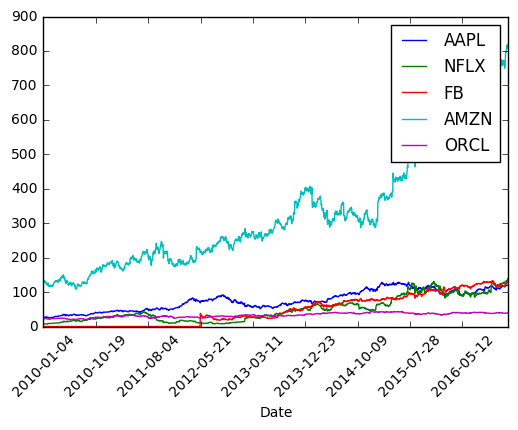

In [3]:
def visualize_data():
    df = df_main
    df.plot()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    
visualize_data()

In [4]:
def correlation():
    df = pd.read_csv('sp500_joined_closes.csv')
    df_five = pd.concat([df.AAPL, df.NFLX, df.FB, df.AMZN, df.ORCL],axis=1)
    df_corr = df_five.corr()
    print(df_corr)

correlation()

          AAPL      NFLX        FB      AMZN      ORCL
AAPL  1.000000  0.786467  0.766247  0.771957  0.861623
NFLX  0.786467  1.000000  0.930759  0.914078  0.779563
FB    0.766247  0.930759  1.000000  0.913273  0.748205
AMZN  0.771957  0.914078  0.913273  1.000000  0.729872
ORCL  0.861623  0.779563  0.748205  0.729872  1.000000


In [5]:
def process_data_for_labels(ticker):
    hm_days = 10
    df = []
    df = df_main
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1, hm_days+1):
        df['{}_{}d'.format(ticker,i)] = (df[ticker].shift(-i)-df[ticker])/df[ticker]
        
    df.fillna(0, inplace=True)
    return tickers, df

In [11]:
process_data_for_labels('AAPL')
process_data_for_labels('NFLX')
process_data_for_labels('FB')
process_data_for_labels('AMZN')
process_data_for_labels('ORCL')

(['AAPL',
  'NFLX',
  'FB',
  'AMZN',
  'ORCL',
  'AAPL_1d',
  'AAPL_2d',
  'AAPL_3d',
  'AAPL_4d',
  'AAPL_5d',
  'AAPL_6d',
  'AAPL_7d',
  'AAPL_8d',
  'AAPL_9d',
  'AAPL_10d',
  'NFLX_1d',
  'NFLX_2d',
  'NFLX_3d',
  'NFLX_4d',
  'NFLX_5d',
  'NFLX_6d',
  'NFLX_7d',
  'NFLX_8d',
  'NFLX_9d',
  'NFLX_10d',
  'FB_1d',
  'FB_2d',
  'FB_3d',
  'FB_4d',
  'FB_5d',
  'FB_6d',
  'FB_7d',
  'FB_8d',
  'FB_9d',
  'FB_10d',
  'AMZN_1d',
  'AMZN_2d',
  'AMZN_3d',
  'AMZN_4d',
  'AMZN_5d',
  'AMZN_6d',
  'AMZN_7d',
  'AMZN_8d',
  'AMZN_9d',
  'AMZN_10d',
  'ORCL_1d',
  'ORCL_2d',
  'ORCL_3d',
  'ORCL_4d',
  'ORCL_5d',
  'ORCL_6d',
  'ORCL_7d',
  'ORCL_8d',
  'ORCL_9d',
  'ORCL_10d',
  'NFLX_target'],
                   AAPL        NFLX          FB        AMZN       ORCL  \
 Date                                                                    
 2010-01-04   27.847252    7.640000    0.000000  133.899994  22.900264   
 2010-01-05   27.895396    7.358572    0.000000  134.690002  22.872617   
 20

In [12]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1
    return 0

In [13]:
def extract_feature(ticker):
    hm_days=10
    tickers, df = process_data_for_labels(ticker)
    df['{}_target'.format(ticker)] = list(map(buy_sell_hold,
                                *[df['{}_{}d'.format(ticker, i)]for i in range(1, hm_days+1)]))
    
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    df.fillna(0, inplace=True)
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    
    return X, y, df